In [80]:
import numpy as np
from variational_staple.unordered import staple, vstaple
from variational_staple.correlated import cstaple
import matplotlib.pyplot as plt

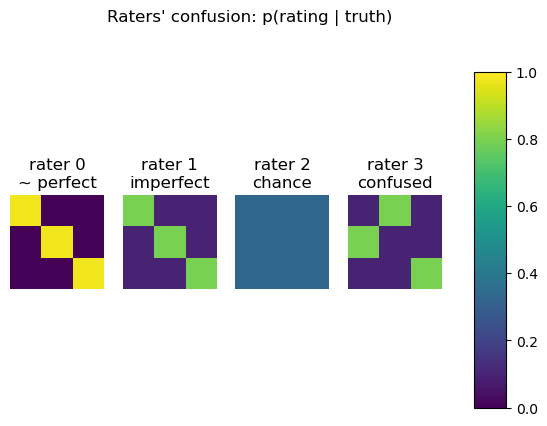

In [81]:
# We define the true performance of 4 raters tasked to classify "things"
# between three classes. Since they are not perfect raters, they
# have a probability of classifiying a "thing" as A even though it was B.
# Each performance matrix gives the probability of rater n of choosing
# class A when it should have been B:
#   true_perf[n, A, B] = P(rater [n] says A | true class is B)
true_perf = [
    [[0.98, 0.01, 0.01], [0.01, 0.98, 0.01], [0.01, 0.01, 0.98]],   # rater 1 (almost perfect)
    [[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]],            # rater 2 (imperfect)
    np.ones([3, 3]) / 3,                                            # rater 3 (chance)
    [[0.1, 0.8, 0.1], [0.8, 0.1, 0.1], [0.1, 0.1, 0.8]],            # rater 4 (confused)
]
true_perf = np.asarray(true_perf)

# check that columns sum to one
rater_labels = ['~ perfect', 'imperfect', 'chance', 'confused']
fig, axes = plt.subplots(1, len(true_perf))
for r, ax in enumerate(axes):
    p = ax.imshow(true_perf[r], vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(f'rater {r}\n{rater_labels[r]}')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Raters\' confusion: p(rating | truth)')
plt.show()

In [82]:
# sample true classes
true_prop = [0.7, 0.2, 0.1]
n = 10000
true_classes = np.random.multinomial(1, true_prop, n).argmax(axis=1)   # [N]

print('Sample of true classes')
print(true_classes[:10])

# sample the raters' choice using the confusion matrices
conditional_confusion = true_perf[:, :, true_classes].transpose(2, 0, 1)          # [N, R, K]
ratings = [np.random.multinomial(1, conditional_confusion[i, j]).argmax()
           for i in range(n) for j in range(len(true_perf))]
ratings = np.asarray(ratings).reshape(n, len(true_perf))

print('Sample of ratings')
print(ratings[:10].T)

Sample of true classes
[2 0 0 0 1 2 0 1 0 0]
Sample of ratings
[[2 0 0 0 1 2 0 1 0 0]
 [2 1 0 0 0 2 0 1 0 0]
 [1 2 0 0 1 0 1 1 1 1]
 [2 1 1 1 0 1 1 0 1 1]]


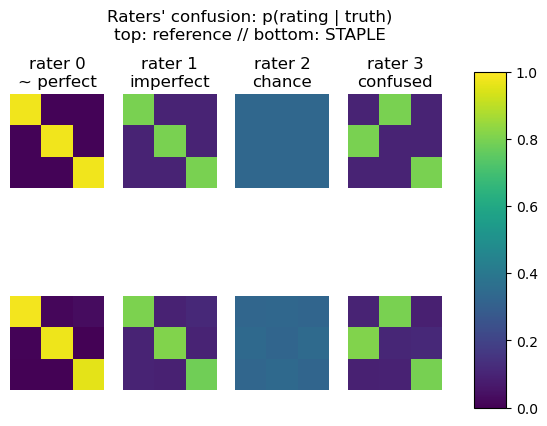

Estimated class proportions
[0.7 0.2 0.1]


In [83]:
# Fit using STAPLE

perf, posterior, prior = staple(ratings)

fig, axes = plt.subplots(2, len(true_perf))
for r, ax in enumerate(axes.T):
    p = ax[0].imshow(true_perf[r], vmin=0, vmax=1)
    ax[0].axis('off')
    ax[0].set_title(f'rater {r}\n{rater_labels[r]}')
    p = ax[1].imshow(perf[r], vmin=0, vmax=1)
    ax[1].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Raters\' confusion: p(rating | truth)\n'
             'top: reference // bottom: STAPLE')
plt.show()

print('Estimated class proportions')
print(np.around(prior, 1))

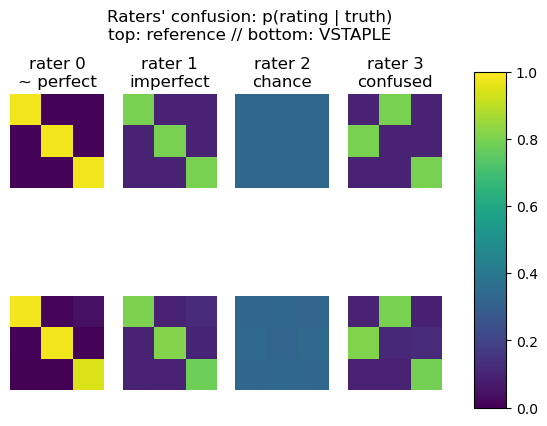

Estimated class proportions
[0.7 0.2 0.1]


In [84]:
# Fit using V-STAPLE (a variant of MAP-STAPLE)

perf, posterior, prior = vstaple(ratings)

fig, axes = plt.subplots(2, len(true_perf))
for r, ax in enumerate(axes.T):
    p = ax[0].imshow(true_perf[r], vmin=0, vmax=1)
    ax[0].axis('off')
    ax[0].set_title(f'rater {r}\n{rater_labels[r]}')
    p = ax[1].imshow(perf[r], vmin=0, vmax=1)
    ax[1].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Raters\' confusion: p(rating | truth)\n'
             'top: reference // bottom: VSTAPLE')
plt.show()

print('Estimated class proportions')
print(np.around(prior, 1))

Estimated rater's variance (conditioned on truth)
[[0.05334136 0.38930464 0.26836364]
 [0.07585189 0.27708845 0.20433602]
 [0.6288481  0.54565095 0.61998689]
 [0.43686597 0.56186907 0.28106357]]


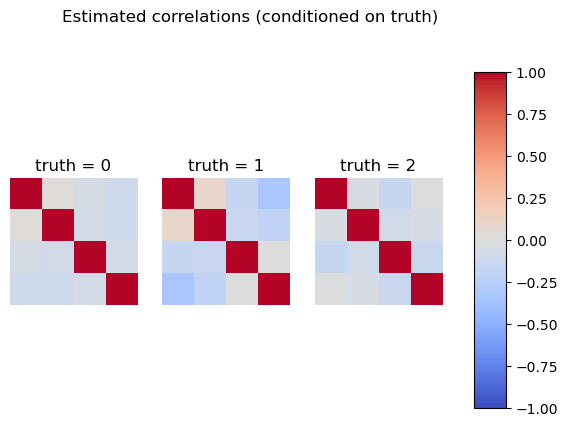

Estimated rater's marginal confusion matrices


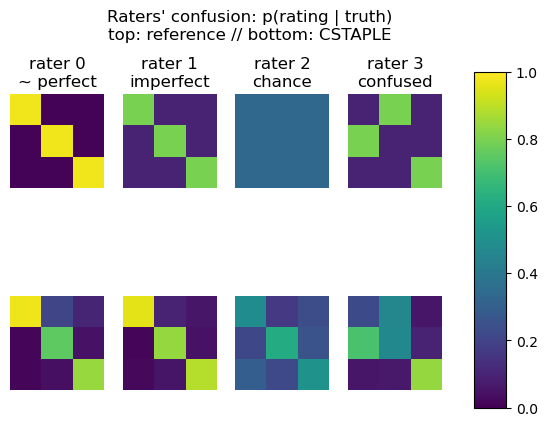

Estimated class proportions
[0.6 0.3 0.1]


In [85]:
# Fit using C-STAPLE (learn correlations)
from variational_staple.correlated import correlation_pairwise, marginal_pairwise

perf, posterior, prior = cstaple(ratings)

# compute correlation
v, c = correlation_pairwise(perf)

print('Estimated rater\'s variance (conditioned on truth)')
print(v)

fig, axes = plt.subplots(1, 3)
for k, ax in enumerate(axes):
    plt.subplot(1, 3, k+1)
    p = plt.imshow(c[..., k], cmap='coolwarm', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title(f'truth = {k}')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Estimated correlations (conditioned on truth)')
plt.show()


print('Estimated rater\'s marginal confusion matrices')
eperf = marginal_pairwise(perf)

fig, axes = plt.subplots(2, len(true_perf))
for r, ax in enumerate(axes.T):
    p = ax[0].imshow(true_perf[r], vmin=0, vmax=1)
    ax[0].axis('off')
    ax[0].set_title(f'rater {r}\n{rater_labels[r]}')
    p = ax[1].imshow(eperf[r], vmin=0, vmax=1)
    ax[1].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Raters\' confusion: p(rating | truth)\n'
             'top: reference // bottom: CSTAPLE')
plt.show()

print('Estimated class proportions')
print(np.around(prior, 1))

Estimated rater's variance (conditioned on truth)
[[0.02832167 0.04352016 0.06559434]
 [0.03726911 0.03867843 0.04214877]
 [0.66662713 0.66666031 0.66662998]
 [0.5272143  0.5713625  0.60552006]]


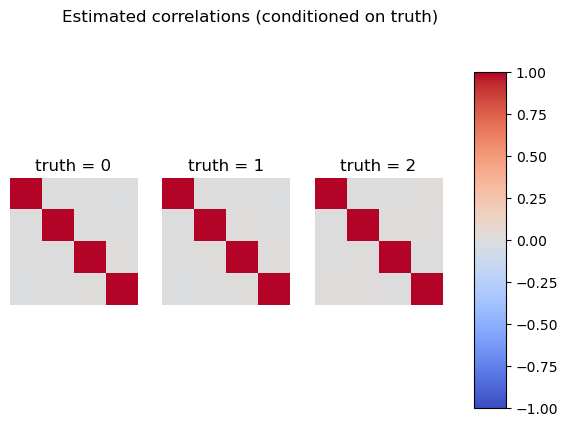

Estimated rater's marginal confusion matrices


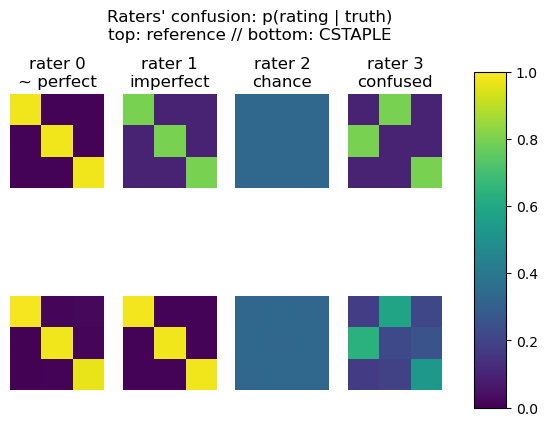

Estimated class proportions
[0.7 0.2 0.1]


In [87]:
# CSTAPLE with a prior that trusts R1 and R2 more

perf, posterior, prior = cstaple(ratings, dirichlet=([5, 5, 0, 0], 10))

# compute correlation
v, c = correlation_pairwise(perf)

print('Estimated rater\'s variance (conditioned on truth)')
print(v)

fig, axes = plt.subplots(1, 3)
for k, ax in enumerate(axes):
    plt.subplot(1, 3, k+1)
    p = plt.imshow(c[..., k], cmap='coolwarm', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title(f'truth = {k}')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Estimated correlations (conditioned on truth)')
plt.show()


print('Estimated rater\'s marginal confusion matrices')
eperf = marginal_pairwise(perf)

fig, axes = plt.subplots(2, len(true_perf))
for r, ax in enumerate(axes.T):
    p = ax[0].imshow(true_perf[r], vmin=0, vmax=1)
    ax[0].axis('off')
    ax[0].set_title(f'rater {r}\n{rater_labels[r]}')
    p = ax[1].imshow(eperf[r], vmin=0, vmax=1)
    ax[1].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Raters\' confusion: p(rating | truth)\n'
             'top: reference // bottom: CSTAPLE')
plt.show()

print('Estimated class proportions')
print(np.around(prior, 1))